In [21]:
import pymongo
import re
from tika import parser

def scrapPDF(file):
    pdf = file
    # pega o texto do pdf
    texto = pdf['content']
    texto = texto.replace('\n', ' ')
    texto = texto.replace('\t', ' ')
    texto = " ".join(texto.split())
    # padroniza as palavras chaves para splits
    texto = texto.replace('As contempladas','Os contemplados')
    texto = texto.replace('Os projetos', 'Os contemplados')
    texto = texto.replace('Os estudantes contemplados', 'Os contemplados')
    texto = texto.replace('[ PROJETO:', '[PROJETO:')
    # separa os premios por tipo
    texto = texto.split('[Prêmios FEBRACE]')[0]
    texto = texto.split('PRÊMIOS DA ORGANIZAÇÃO DA FEBRACE NA VOTAÇÃO POPULAR')[0]
    # separa por empresa
    texto = texto.split('[EMPRESA/INSTITUIÇÃO]')
    texto = texto[1:]

    def scrapPage(page):
        empresa = texto[page].split('[PRÊMIO]')
        premio = empresa[1].split('Os contemplados')
        projeto = premio[1].split('[PROJETO:')[1].split(']')
        projetoJunto = "]".join(projeto)
        projeto[1] = projeto[1].replace('–', '-') # mais uma padronizacao
        separator = re.findall('- [A-Z][A-Z] ', projeto[1])
        cidade = projetoJunto.split(separator[0])
        estado = separator[0].split(' ')
        alunos = cidade[1].split(" [Estudante] ")
        orientador = alunos.pop()
        orientador = orientador.split('[Orientador(a)]')
        coorientadores = orientador[1]
        empresa_ = empresa[0].strip()
        premio_ = premio[0].strip()
        projeto_ = projeto[0].split(']')[0].strip()
        cidade[0] = cidade[0].replace('Do', 'De') # sim cara, mais uma
        cidade_ = cidade[0].split(' De ')[1].strip()
        estado_ = estado[1].strip()
        alunos_ = ', '.join(alunos)
        orientador_ = orientador[0]
        coorientador_ = orientador[1].split('[Coorientador(a)]')[0].strip()
        
        return { "empresa": empresa_, "premio": premio_, "projeto": projeto_, "cidade": cidade_, "estado": estado_, "alunos": alunos_, "orientador": orientador_, "coorientador": coorientador_ }
    
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client["datascience"]
    col = db["premiados"]

    for pg in range(len(texto)):
        try:
            col.insert_one(scrapPage(pg))
        except Exception as e:
            print(e)

In [24]:
from os import walk

_, _, filenames = next(walk('./pdfs'))

for f in filenames:
    scrapPDF(parser.from_file('pdfs/'+f))

In [19]:
import pandas as pd
df = pd.DataFrame(data = col.find(), columns=['empresa', 'premio', 'projeto', 'cidade', 'estado', 'alunos', 'orientador'])
estadoCount = df.pivot_table(index=['estado'], aggfunc='size')
estadoCount

estado
AL     6
AP     3
BA    18
CE    18
GO     3
MA    12
MG    21
MS    18
PA    15
PE     9
PR    21
RJ    12
RN    21
RR     6
RS    54
SC    12
SE     9
SP    81
TO     3
dtype: int64

<AxesSubplot:title={'center':'Empresas que mais premiaram'}, ylabel='empresa'>

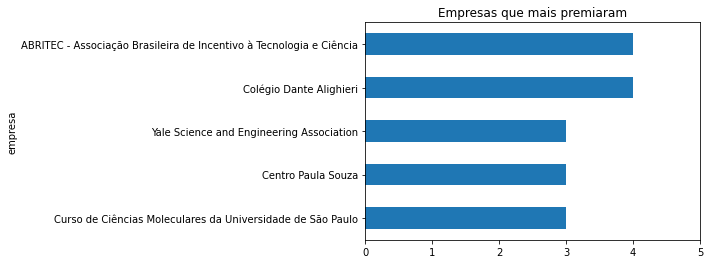

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(list(col.find()))
df.to_csv('sample.csv')
df = pd.read_csv('sample.csv')

df['empresa'].unique()

# df.head()
estadoRN = df[df['estado'].str.match(r'RN')]
cidadesRN = estadoRN.pivot_table(index=['cidade'], aggfunc='size')
cidadesRN.plot(x='cidade', kind='barh', title='Cidades do RN que já ganharam', xlim=(0,5))

estados = df.pivot_table(index=['estado'], aggfunc='size').sort_values()
estados.plot(x='estado', kind='barh', title='Quantidade de ganhadores por estado')

empresa = df.pivot_table(index=['empresa'], aggfunc='size').sort_values()
empresa.tail().plot(x='empresa', kind='barh', title='Empresas que mais premiaram')